# Introduction

In this project, we build a neural network to evaluate the MNIST dataset.

Some of the benchmark results on MNIST include can be found [on Yann LeCun's page](https://webcache.googleusercontent.com/search?q=cache:stAVPik6onEJ:yann.lecun.com/exdb/mnist) and include:

88% [Lecun et al., 1998](https://hal.science/hal-03926082/document)

95.3% [Lecun et al., 1998](https://hal.science/hal-03926082v1/document)

99.65% [Ciresan et al., 2011](http://people.idsia.ch/~juergen/ijcai2011.pdf)


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

In [15]:
# Define transformations for the data
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert the data to a PyTorch tensor
    transforms.Normalize(mean=(0.5,), std=(0.5,)),  # Normalize the data using `;`(data - 0.5) / 0.5`, hence [0, 1] -> [-1, 1]
    transforms.Lambda(lambda x: x.view(-1))  # Flatten the data
])

# Load the MNIST dataset
full_train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split into training and validation datasets (80% training, 20% validation)
train_dataset, val_dataset = random_split(full_train_dataset, [0.8, 0.2])

test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Create DataLoaders for training, validation, and testing datasets
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [16]:
# show the size and shape of the training and test data:
print(f"Training dataset size: {len(train_dataset)}, shape: {train_dataset[0][0].shape}")
print(f"Validation dataset size: {len(val_dataset)}, shape: {val_dataset[0][0].shape}")
print(f"Test dataset size: {len(test_dataset)}, shape: {test_dataset[0][0].shape}")

Training dataset size: 48000, shape: torch.Size([784])
Validation dataset size: 12000, shape: torch.Size([784])
Test dataset size: 10000, shape: torch.Size([784])


## Justify preprocessing:
Preprocessing steps are necessary to ensure that the data is in the correct format for training neural networks and to help the model converge faster. The following preprocessing steps are applied to the MNIST dataset:
1. **ToTensor**: This converts the input data to a PyTorch tensor, which is required for further processing by the neural network.
2. **Normalization**: Normalizing the data helps in faster convergence during training, as most neural networks perform better when the input data has a consistent scale around 0, as it helps in stabilizing the gradients during training.
3. **Flattening**: The neural network model expects a 1D tensor as input, so we flatten the 28x28 images into a 784-dimensional vector.

## Explore the Dataset


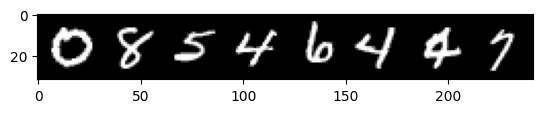

    0     8     5     4     6     4     4     7


In [17]:
# DataLoader for visualization (without normalization and flattening)
visualize_transform = transforms.Compose([
    transforms.ToTensor()
])

visualize_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=visualize_transform)
visualize_loader = DataLoader(visualize_dataset, batch_size=8, shuffle=True)

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images
images, labels = next(iter(visualize_loader))

# Show images
imshow(utils.make_grid(images))

# Print labels
print(' '.join('%5s' % labels[j].item() for j in range(8)))

## Build the Neural Network

In [18]:
# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 512)
        self.fc2 = nn.Linear(512, 128)
        self.fc3 = nn.Linear(128, 10)

    def forward(self, x):
        """outputs a prediction probability for each of the 10 classes using softmax."""
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.log_softmax(self.fc3(x), dim=1)
        return x


Specify a loss function and an optimizer, and instantiate the model.


In [19]:
net = Net()
criterion = nn.NLLLoss()  # Use NLLLoss as the loss function since the output is LogSoftmax
optimizer = optim.SGD(net.parameters(), lr=0.02, momentum=0.9)

## Running the Neural Network

In [20]:
# Training the network with validation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net.to(device)

train_losses = []
val_losses = []
epochs = 5
tolerance = 2
for epoch in range(1, epochs + 1):
    net.train()  # Set the model to training mode
    batch_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        images, labels = data
        images, labels = images.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward + backward + optimize
        outputs = net.forward(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        batch_loss += loss.item()
    
    batch_loss /= len(train_loader)
    train_losses.append(batch_loss)
    print(f'Epoch {epoch + 1}, Loss: {batch_loss:.3f}')

    # Validation step
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = net.forward(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    val_accuracy = 100 * correct / total
    print(f'Validation Loss: {val_loss:.3f}, Validation Accuracy: {val_accuracy:.2f}%')
    # early stopping:
    if epochs > epoch > 0 and val_losses[-1] > val_losses[-2]:
        tolerance -= 1
        if tolerance == 0:
            print(f"Early stopping at epoch {epoch + 1}")
            break

print('Finished Training')


Epoch 1, Loss: 0.370
Validation Loss: 0.226, Validation Accuracy: 92.68%
Epoch 2, Loss: 0.157
Validation Loss: 0.146, Validation Accuracy: 95.13%
Epoch 3, Loss: 0.113
Validation Loss: 0.129, Validation Accuracy: 96.19%
Epoch 4, Loss: 0.089
Validation Loss: 0.107, Validation Accuracy: 96.81%
Epoch 5, Loss: 0.071
Validation Loss: 0.098, Validation Accuracy: 97.20%
Finished Training


Plot the training and validation loss.

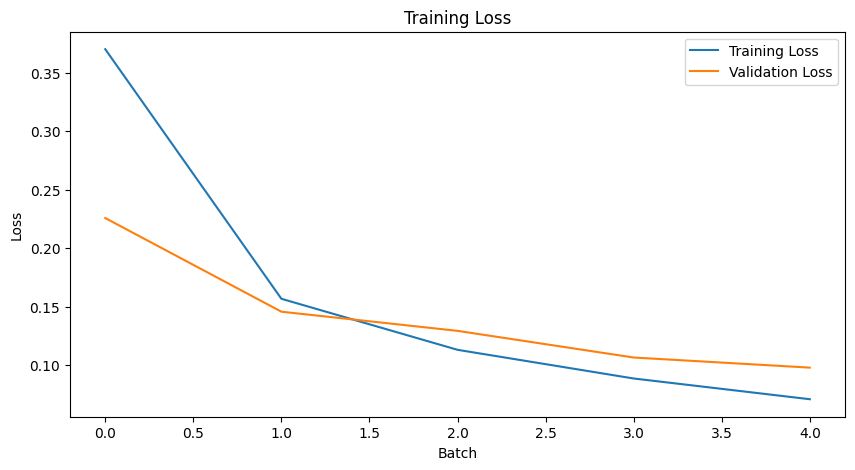

In [21]:
plt.figure(figsize=(10, 5))
plt.title('Training Loss')
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Testing the model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

In [22]:
# Evaluate the network on the test data
correct = 0
total = 0
wrong_images = []
with torch.no_grad():
    for data in test_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net.forward(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        if any(predicted != labels):
            for t in zip(images[predicted != labels], predicted[predicted != labels], labels[predicted != labels]):
                wrong_images.append(t)

print(f'Accuracy of the network on the {len(test_dataset)} test images: {100 * correct / total:.2f}%')


Accuracy of the network on the 10000 test images: 97.23%


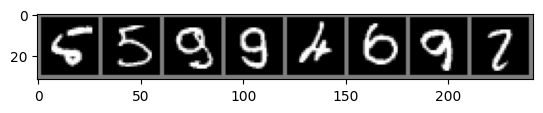

Predicted:  6 3 8 8 6 0 3 7
Actual:     5 5 9 9 4 6 9 2


In [27]:
# Display some of the wrongly classified images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()    
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

images = wrong_images[:8]
images, predicted, actual = zip(*images)
# unflatten:
images = [image.view(1, 28, 28) for image in images]
imshow(utils.make_grid(images))
print('Predicted: ', ' '.join(f'{predicted[j].item()}' for j in range(8)))
print('Actual:    ', ' '.join(f'{actual[j].item()}' for j in range(8)))


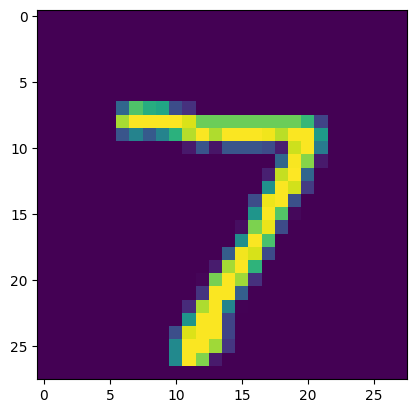

Predicted: 7, Actual: 7


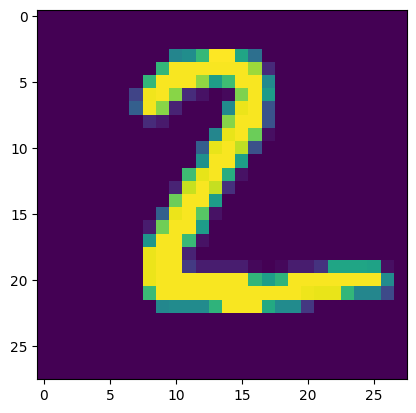

Predicted: 2, Actual: 2


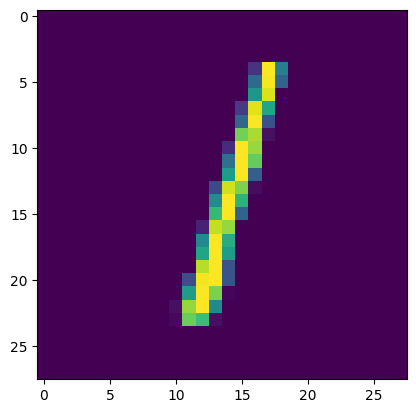

Predicted: 1, Actual: 1


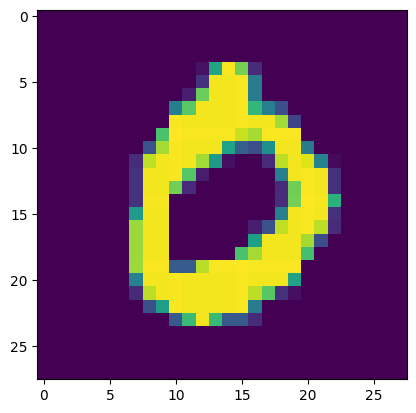

Predicted: 0, Actual: 0


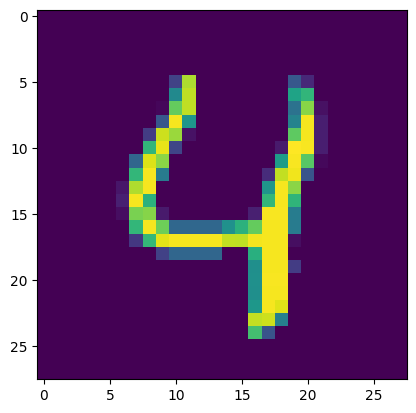

Predicted: 4, Actual: 4


In [24]:
# Sanity check: test & display on random images
images, labels = next(iter(test_loader))
net.eval()  # Set the model to evaluation mode
outputs = net.forward(images)

# Get the predicted classes
_, predicted = torch.max(outputs, 1)

# Print predictions and actual labels
for i in range(5):
    imshow(images[i].view(1, 28, 28))
    print(f'Predicted: {predicted[i].item()}, Actual: {labels[i].item()}')



## Saving your model

In [25]:
torch.save(net.state_dict(), 'mnist_net.pth')